In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import copy
import os
import deap

# --- Importaciones para GA ---

from deap import base, creator, tools, algorithms
from myutils.dataloader import cargar_todo_el_sistema
from arch.genetic_optimizer import OptimizadorHorarios
from src.graficar_horarios import plot_horario_plotly, plot_horario_interactivo



# --- Importaciones para ACO (Milagrito) ---    
from myutils.datos_horarios import TimetablingData
from arch.evaluacion_horarios import TimetablingEvaluator
from arch.aco_horarios import ACOTimetabler



# Configuración visual
%matplotlib inline
plt.style.use('ggplot')
print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


In [2]:
# 1. Cargar datos para el GA
datos_ga = cargar_todo_el_sistema()
SEED = 1          # o el número que quieras
random.seed(SEED)      # Semilla global de python
np.random.seed(SEED)   # Semilla global de numpy
print(f"Semilla fija establecida: {SEED}")

# 2. Instanciar clase Optimizador (

optimizer = OptimizadorHorarios(datos_ga, seed=SEED)

# 3. Configurar DEAP
if hasattr(creator, "FitnessMax"):
    del creator.FitnessMax
if hasattr(creator, "Individual"):
    del creator.Individual
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", dict, fitness=creator.FitnessMax)
toolbox = base.Toolbox()

# Creación de individuos
toolbox.register("crear_horario_dict", optimizer.crear_individuo)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.crear_horario_dict)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("clone", copy.deepcopy)

# Evaluación
toolbox.register("evaluate", lambda ind: (optimizer.evaluar_horario(ind)[0], ))

# Operadores Genéticos
toolbox.register("mutate", optimizer.mutar_horario) 
toolbox.register("mate", optimizer.crossover_horarios)

# Selección (se mantiene igual)
toolbox.register("select", tools.selTournament, tournsize=6)

print(f"Configuración del GA completada con semilla fija (SEED={SEED}).")

--- Iniciando Dataloader ---
Datos cargados: 11 asig, 8 tipos aula, 14 clases, 23 profes.
Total de tareas (horas lectivas) a programar: 448
--- Dataloader Finalizado Correctamente ---
Semilla fija establecida: 1
Configuración del GA completada con semilla fija (SEED=1).


In [3]:
def ejecutar_ga_con_historial(POBLACION_TAM=250, 
                              GENERACIONES=400, 
                              PROB_CRUCE=0.9, 
                              PROB_MUTACION=0.18, 
                              STUCK_LIMIT=50, 
                              MAX_RESTARTS=5, 
                              seed_inicial=None, 
                              devolver_intento=False):
    
    mejor_ind = None
    historial_fitness = []  # Guardará el mejor fitness de cada generación
    intento_con_solucion = 0 # 0 = no hubo solución factible

    # Si no dan semilla, generamos una aleatoria base
    if seed_inicial is None:
        seed_inicial = random.randint(0, 10000)

    for intento in range(1, MAX_RESTARTS + 1):
        print(f"\n========== INTENTO GA {intento}/{MAX_RESTARTS} ==========")

        seed_intento = seed_inicial + (intento - 1)
        
        # Afecta a Python standard (y por tanto a tu clase OptimizadorHorarios)
        random.seed(seed_intento) 
        
        # Afecta a Numpy (si usas distribuciones de numpy en estadísticas o algun lado)
        np.random.seed(seed_intento)
        
        
        if 'optimizer' in globals():
            optimizer.seed = seed_intento

        print(f"--> Semilla aplicada para este intento: {seed_intento}")

        # -------------------------------------------------------------
        # 2. REINICIO DE LA POBLACIÓN
        # -------------------------------------------------------------
        # Al llamar a toolbox.population(), DEAP usará toolbox.individual(),
        # que a su vez llama a optimizer.crear_individuo(). 
        # Como ya cambiamos la seed arriba, los individuos serán diferentes.
        poblacion = toolbox.population(n=POBLACION_TAM)
        
        # Evaluar población inicial
        fitnesses = list(map(toolbox.evaluate, poblacion))
        for ind, fit in zip(poblacion, fitnesses):
            ind.fitness.values = fit
        
        # Estadísticas
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("max", np.max)
        stats.register("avg", np.mean)
        
        hof = tools.HallOfFame(1)
        hof.update(poblacion)
        
        best_run = 0
        gens_sin_mejora = 0
        factible = False
        
        # Bucle generacional
        for gen in range(1, GENERACIONES + 1):
            offspring = algorithms.varAnd(
                poblacion, toolbox,
                cxpb=PROB_CRUCE,
                mutpb=PROB_MUTACION
            )
            
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit
            
            poblacion = toolbox.select(offspring, len(offspring))
            hof.update(poblacion)
            
            record = stats.compile(poblacion)
            current_max = record["max"]
            historial_fitness.append(current_max) 
            
            if gen % 10 == 0:
                print(f"Gen {gen}: Max Fitness {current_max:.4f}")

            # ¿Solución factible? (Fitness 2.0 es factible en tu lógica)
            if current_max >= 2.0 - 1e-9:
                print(f"¡SOLUCIÓN FACTIBLE ENCONTRADA! (Gen {gen})")
                factible = True
                intento_con_solucion = intento
                break
            
            # Control de estancamiento
            if current_max > best_run + 1e-9:
                best_run = current_max
                gens_sin_mejora = 0
            else:
                gens_sin_mejora += 1
                
            if gens_sin_mejora >= STUCK_LIMIT:
                print(f"Estancamiento por {STUCK_LIMIT} generaciones. Reiniciando intento...")
                break
        
        # Guardamos el mejor de este intento
        current_best = hof[0]
        
        
        # Si encontramos factible, terminamos todo el proceso
        if factible:
            mejor_ind = current_best
            break
        
        # Si no es factible, guardamos el mejor encontrado hasta ahora por si agotamos intentos
        if mejor_ind is None or current_best.fitness.values[0] > mejor_ind.fitness.values[0]:
            mejor_ind = current_best

    print("\nProceso finalizado.")
    
    if devolver_intento:
        return mejor_ind, historial_fitness, intento_con_solucion
    else:
        return mejor_ind, historial_fitness

# Ejecución de prueba
solucion_ga, historia_ga, n_intento = ejecutar_ga_con_historial(devolver_intento=True)


========== INTENTO GA 1/5 ==========
--> Semilla aplicada para este intento: 2201
Gen 10: Max Fitness 0.0055
Gen 20: Max Fitness 0.0094
Gen 30: Max Fitness 0.0147
Gen 40: Max Fitness 0.0222
Gen 50: Max Fitness 0.0455
Gen 60: Max Fitness 0.0714
Gen 70: Max Fitness 0.2000
¡SOLUCIÓN FACTIBLE ENCONTRADA! (Gen 74)

Proceso finalizado.


In [4]:
from src.factible import es_factible

factibilidad = es_factible(
    solucion_ga,                   # La solución en formato diccionario
    datos_ga['tasks_df'],       # DataFrame de tareas
    datos_ga['prof_subject'],   # Diccionario profe-asignatura
    datos_ga['prof_max_hours'], # Horas máx profe
    datos_ga['valid_rooms'],# Aulas válidas
    datos_ga['rooms_df'],       # DataFrame de aulas
    datos_ga['Hmax_subject_day'], # Horas máx asignatura/día
    datos_ga['Hmax_prof_day']     # Horas máx profe/día
)

print(f'¿Es factible? {factibilidad}')


# 1. Cargar datos usando la clase específica de ACO (como en Milagrito)
data_aco = TimetablingData.from_csv_folder(data_folder="data")

# 2. Crear evaluador
evaluator_aco = TimetablingEvaluator(data_aco, H_ideal=1, Us=3)
sol_inicial_aco = dict(solucion_ga)  # Convertir DEAP Individual a dict

# 4. Calcular coste inicial
coste_inicial = evaluator_aco.cost(sol_inicial_aco)
print(f"Coste inicial (Salida GA): {coste_inicial:.3f}")


¿Es factible? True
Coste inicial (Salida GA): 22054.442


In [5]:
def guardar_csv_intermedio(solucion, datos, filename="horario_factible.csv"):
    tasks_df = datos["tasks_df"]
    filas = []

    # Iteramos sobre el diccionario de solución
    # Estructura esperada: task_id -> (profesor, (dia, periodo), aula)
    for task_id, (prof_asignado, (dia, periodo), aula_asignada) in solucion.items():
        
        # Obtenemos la info estática de la tarea desde el DataFrame original
        task_info = tasks_df.loc[task_id]
        
        # Construimos la fila
        fila = {
            "Task_ID": task_id,
            # Usamos .get() y claves en minúscula (basado en tus archivos previos) 
            # para evitar errores si la columna se llama 'subject' en lugar de 'Course'
            "Course": task_info.get("subject", task_info.get("Course", "N/A")), 
            "Group": task_info.get("group", task_info.get("Group", "N/A")),
            
            # IMPORTANTE: Usamos el profesor de la SOLUCIÓN (el que asignó el GA), 
            # no el original del excel (que podría haber mutado)
            "Professor": prof_asignado,
            
            # Desglosamos el slot en Día y Periodo para que el CSV sea más legible
            "Day": dia,
            "Period": periodo,
            "Room": aula_asignada
        }
        filas.append(fila)
    
    df_resultado = pd.DataFrame(filas)
    
    # Ordenamos por Día y Periodo para que el CSV sea legible cronológicamente
    if not df_resultado.empty:
        df_resultado = df_resultado.sort_values(by=["Day", "Period", "Course"])

    df_resultado.to_csv(filename, index=False)
    print(f"Horario guardado exitosamente en: {filename}")

# Llamada a la función
if solucion_ga is not None:
    guardar_csv_intermedio(solucion_ga, datos_ga, filename="horario_factible.csv")
else:
    print("No hay solución para guardar (solucion_ga es None).")

Horario guardado exitosamente en: horario_factible.csv


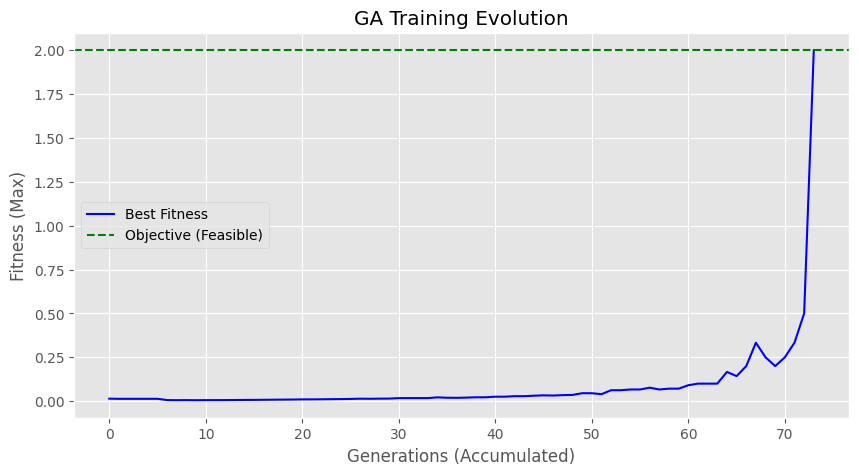

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(historia_ga, label="Best Fitness", color='blue')
plt.axhline(y=2.0, color='green', linestyle='--', label="Objective (Feasible)")
plt.xlabel("Generations (Accumulated)")
plt.ylabel("Fitness (Max)")
plt.title("GA Training Evolution")
plt.legend()
plt.show()

In [7]:
# --- EXPERIMENTO: 10 repeticiones del GA con semillas distintas ---

import collections
import matplotlib.pyplot as plt

NUM_REP = 10      # número de repeticiones del experimento
SEED_BASE = 1     # semilla base (cámbiala si quieres otro experimento)

resultados_intento = []   # aquí guardamos el intento (1..5) o 0 si no hay solución

for rep in range(NUM_REP):
    seed = SEED_BASE + 5 * rep  # semillas distintas para cada repetición
    print("\n========================")
    print(f"REPETICIÓN {rep+1}/{NUM_REP} con seed_base={seed}")
    print("========================")

    # Ahora el GA NOS DICE en qué intento encontró la solución
    sol, hist, intento = ejecutar_ga_con_historial(
        seed_inicial=seed,
        devolver_intento=True
    )
    resultados_intento.append(intento)

# =============================
# Construir frecuencias y graficar
# =============================
conteo = collections.Counter(resultados_intento)

frecs = [
    conteo.get(1, 0),  # soluciones en el 1er intento
    conteo.get(2, 0),  # 2º intento
    conteo.get(3, 0),  # 3er intento
    conteo.get(4, 0),  # 4º intento
    conteo.get(5, 0),  # 5º intento
    conteo.get(0, 0),  # sin solución
]

labels = [
    "1st try",
    "2nd try",
    "3rd try",
    "4th try",
    "5th try",
    "No solution",
]

plt.figure(figsize=(8, 5))
plt.bar(labels, frecs)
plt.ylabel(f"Frequency (over {NUM_REP} runs)")
plt.title("Attempt in which the GA finds a feasible solution")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

print("\nResults per run (0 = no solution):")
print(resultados_intento)



REPETICIÓN 1/10 con seed_base=1

========== INTENTO GA 1/5 ==========
--> Semilla aplicada para este intento: 1


KeyboardInterrupt: 